In [1]:
'''
Import of all required libraries
and paths
'''
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import os
%matplotlib inline

os.getcwd()
os.chdir('C:/Users/johan/Python_Projects/Udacity/Project1')

### First Look at the data

In [2]:
'''
Define Sources and take a look at the data
'''
src = "AirBnB_Dataset/"
df = pd.read_csv(src + "listings.csv")

print(df.shape)
df.head()

(3818, 92)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


### Evaluation 

### Modelling 

In [3]:
def clean_data_amenities(df, dep_var):
    '''
    INPUT
    df - pandas dataframe
    dep_var - name of dependent variable
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no rating
    2. Split up the information given in lists/dictionaries into individual columns
    3. Drop all unnecessary columns
    4. Remove symbols
    5. Filter for a minimum amount of reviews
    6. Translate t/f to boolean
    7. For each numeric variable in df, fill the column nan values with the mean value of the column and normalize
    8. Create dummy columns for all the categorical variables in X, drop the original columns
    9. Create X and y
    '''
    # 1. Drop all the rows with no rating
    df = df.dropna(subset=[dep_var], axis=0)
    df = df.filter(['amenities', 'number_of_reviews',dep_var])
    
    # 2. Split up the information given in lists/dictionaries into individual columns
    ## Amenities
    amenities = [x.strip(' ').strip('""') for x in set(df['amenities'].str.strip('{}').str.split(',').sum())][1:]
    for amenity in amenities:
        df['amenities_'+amenity] = df['amenities'].str.contains(amenity)
    df = df.drop(['amenities'], axis=1)  
    
    # 5. Filter for a minimum amount of reviews
    df = df[df['number_of_reviews']>10]
    
    # 6. Translate t/f to boolean
    df = df.replace('t', True)
    df = df.replace('f', False)
    
    df[dep_var] = (df[dep_var]-df[dep_var].min())/(df[dep_var].max()-df[dep_var].min()) #normalize
        
    # 8. Create dummy columns for all the categorical variables in X, drop the original columns
    cat_cols = df.select_dtypes(include=['object']).copy().columns.difference([dep_var])
    for col in  cat_cols:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
    
    for col in list(df):
        if list(df[col].value_counts())[0] > len(df[col])*0.99:
            df = df.drop(col, axis=1)
    
    # 9. Create X and y
    y = df[dep_var]
    X = df.drop(dep_var, axis=1)
    X = X.drop('number_of_reviews', axis=1)
    
    return X, y
    
#Use the function to create X and y
X, y = clean_data_amenities(df, 'review_scores_rating')  

C:\Users\johan\AppData\Local\Temp/ipykernel_23800/2700872983.py:30: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['amenities_'+amenity] = df['amenities'].str.contains(amenity)


In [4]:
def find_best_model(X, y, cutoffs, test_size):
    '''
    source of the function: Udacity Nanodegree DataScience, adapted
    
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars

    OUTPUT
    lm_model - model object from sklearn
    
    This function finds the ideal cutoff number to get the best model
    1. For each of the cutoffs to try:
    1.1. Remove the categorical variables with less entries than the cutoff
    1.2. Perform a train test split
    1.3. Fit and test the linear regression model
    1.4. Document the results
    2. Plot the results
    3. Choose the best cutoff and apply it
    4. Perform a train test split
    5. Fit the model
    ''' 
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    #1. For each of the cutoffs to try:
    for cutoff in cutoffs:

        #1.1. Remove the categorical variables with less entries than the cutoff
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #1.2. Perform a train test split
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=42)

        #1.3. Fit and test the linear regression model
        lm_model = LinearRegression()
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #1.4. Document the results
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    #2. Plot the results
    fig, ax = plt.subplots(figsize=(10,5))
    plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
    plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
    plt.xlabel('Number of Features')
    plt.ylabel('Rsquared')
    plt.title('Rsquared by Number of Features')
    plt.legend(loc=1)
    plt.show()
    
    #3. Choose the best cutoff and apply it
    best_cutoff = max(results, key=results.get)
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #4. Perform a train test split
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=42)

    #5. Fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)
    y_test_preds = lm_model.predict(X_test)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test, y_test_preds

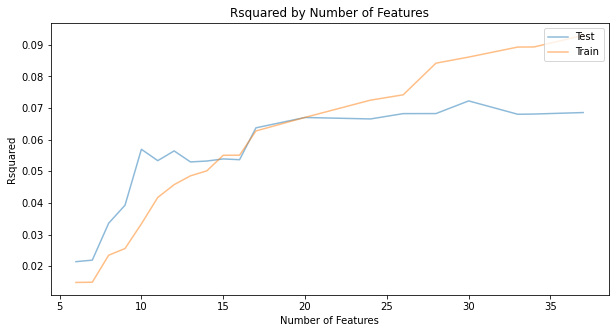

R² Score: 0.07225217386607163


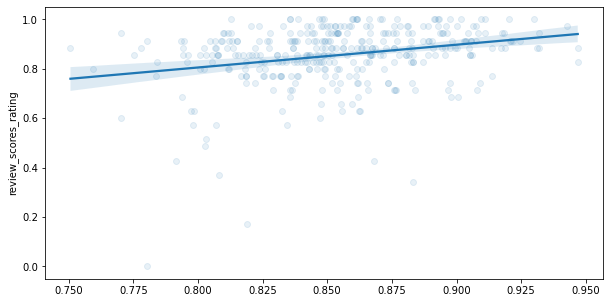

In [5]:
#Use the function to get the best model
cutoffs = np.arange(0,1500, 50).tolist()
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test, y_test_preds = find_best_model(X, y, cutoffs, test_size=.2)

#Investigate the results using a regplot and the R2 score test
print("R² Score: "+str(max(r2_scores_test)))
fig, ax = plt.subplots(figsize=(10,5))
sns.regplot(x = y_test_preds, y = y_test, scatter_kws={'alpha':0.1});

### Evaluation 

In [9]:
def coef_weights(coefficients, X_train):
    '''
    source of the function: Udacity Nanodegree DataScience, adapted
    
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['variable'] = X_train.columns
    coefs_df['coefficient'] = lm_model.coef_
    coefs_df['abs_coefficient'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefficient', ascending=False)
    return coefs_df

In [10]:
#Use the coef function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,variable,coefficient,abs_coefficient
10,amenities_Wireless Internet,0.033190,0.033190
1,amenities_Pets Allowed,-0.030133,0.030133
26,amenities_Pets live on this property,0.028201,0.028201
11,amenities_Shampoo,0.024744,0.024744
12,amenities_Air Conditioning,0.023256,0.023256
22,amenities_TV,0.023061,0.023061
4,amenities_Buzzer/Wireless Intercom,-0.022881,0.022881
27,amenities_Laptop Friendly Workspace,0.020840,0.020840
14,amenities_Internet,-0.018489,0.018489
25,amenities_Carbon Monoxide Detector,0.018372,0.018372


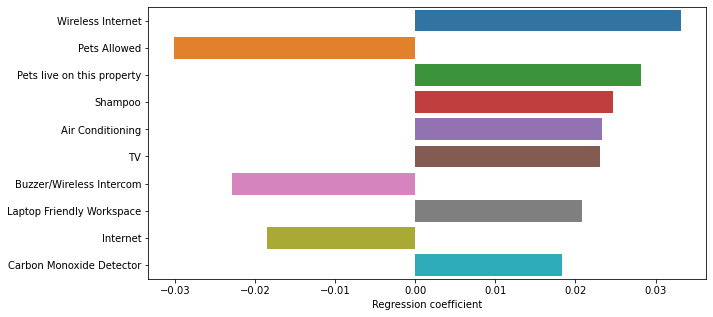

In [11]:
#Plot the best results

plt.subplots(figsize=(10,5))
ax = sns.barplot(data=coef_df[:10], y = [x.split('_')[-1] for x in coef_df[:10]['variable']], x='coefficient')
plt.xlabel('Regression coefficient')
plt.show()